<a href="https://colab.research.google.com/github/Ekalabya3/Abhilash-2D2V/blob/main/Copy_of_Abhilash_2D_PIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
from scipy.fft import fftfreq, fft2, ifft2
import matplotlib.pyplot as plt

In [35]:
def periodic_particles(x, y, length):

    rem_x = x % length;
    if x > length:
      x = rem_x;
    elif x < 0:
      x = length - rem_x;

    rem_y = y % length
    if y > length:
      y = rem_y;
    elif y < 0:
      y = length - rem_y ;

    return x, y

In [36]:
def ghost(rho):
    Nx, Ny = rho.shape
    for i in range(Nx):
        rho[i, 0] = rho[i, Ny - 2]
        rho[i, Ny - 1] = rho[i, 1]

    for j in range(Ny):
        rho[0, j] = rho[Nx - 2, j]
        rho[Nx - 1, j] = rho[1, j]
    return rho

In [37]:
def charge_density(pos_x, pos_y, dx, dy, length):    #DONE

    charge_density = np.zeros((int(ncell ** 0.5)+1 +2  , int(ncell ** 0.5)+1 +2 ))    # + 2                             #+ 2*nghost

    # LOOPING
    for p in range(nparticles):
        pos_x[p], pos_y[p] = periodic_particles(pos_x[p], pos_y[p], length)

        # GRID POINT FINDER
        i = int(pos_x[p] / dx)   +1
        j = int(pos_y[p] / dy)   +1

        # FRACTION FINDER
        x_frac = ((pos_x[p]+dx) - (i * dx)) / dx   #+dx
        y_frac = ((pos_y[p]+dy)  - (j * dy)) / dy   #+dy
        # WEIGHT FINDER
        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0
        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0
        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1
        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1

        charge_density[i][j]     =   charge_density[i][j]     + (particle_charge * weight_ii)           #/ (dx*dy)
        charge_density[(i+1)][j]   =   charge_density[(i+1)][j]   + (particle_charge * weight_ji)       #/ (dx*dy)
        charge_density[i][(j+1)]   =   charge_density[i][(j+1)]   + (particle_charge * weight_ij)       #/ (dx*dy)
        charge_density[(i+1)][(j+1)] =   charge_density[(i+1)][(j+1)] + (particle_charge * weight_jj)   #/ (dx*dy)


        #transpose_charge_density = np.transpose(charge_density_without_ghost)
        #rho_1 = (np.flip(transpose_charge_density, 0)) / (dx*dy)

        rho_1 = charge_density / (dx * dy)

    return  rho_1

In [38]:

def calculate_background_charge_density(dx, dy, length, particle_charge, nparticles):  #DONE

    # FIRST: TOTAL CHARGE CALCULATION
    total_particle_charge = particle_charge * nparticles

    # SECOND: TOTAL NUMBER OF GRID POINTS
    num_x_grid_points = int(ncell ** 0.5) + 1
    num_y_grid_points = int(ncell ** 0.5) + 1
    total_grid_points = num_x_grid_points * num_y_grid_points

    # THIRD: CHARGE DENSITY BY BACKGROUND PARTICLES (IONS)
    background_charge_density = (np.ones((num_x_grid_points, num_y_grid_points)) * (-total_particle_charge / total_grid_points)) / (dx * dy)  #(length*length)

    background_charge_density_frame = np.zeros((num_x_grid_points + 2, num_y_grid_points + 2))
    background_charge_density_frame [1:-1, 1:-1] = background_charge_density

    return background_charge_density, background_charge_density_frame


In [39]:
'''
def poisson_solver(rho, dx, dy):
    # Calculate Wavenumbers
    k_x = fftfreq(rho.shape[1], dx)
    k_y = fftfreq(rho.shape[0], dy)

    # Compute Fourier transform of charge density
    rho_hat = fft2(rho)

    # Compute potential in Fourier space
    kx_grid, ky_grid = np.meshgrid(k_x, k_y, indexing='ij')
    kx_grid_sq = kx_grid ** 2
    ky_grid_sq = ky_grid ** 2
    k_sq = kx_grid_sq + ky_grid_sq

    # Avoid division by zero at zero frequency
    k_sq[0, 0] = 1.0
    potential_hat = rho_hat / (4 * np.pi ** 2 * k_sq)

    # Compute electric field components in Fourier space
    E_x_hat = -1j * 2 * np.pi * kx_grid * potential_hat
    E_y_hat = -1j * 2 * np.pi * ky_grid * potential_hat

    # Compute inverse Fourier transform to get electric field in real space
    E_x = np.real(ifft2(E_x_hat))
    E_y = np.real(ifft2(E_y_hat))
    electric_potential = np.real(ifft2(potential_hat))

    return E_x, E_y, k_sq, electric_potential
'''

"\ndef poisson_solver(rho, dx, dy):\n    # Calculate Wavenumbers\n    k_x = fftfreq(rho.shape[1], dx)\n    k_y = fftfreq(rho.shape[0], dy)\n\n    # Compute Fourier transform of charge density\n    rho_hat = fft2(rho)\n\n    # Compute potential in Fourier space\n    kx_grid, ky_grid = np.meshgrid(k_x, k_y, indexing='ij')\n    kx_grid_sq = kx_grid ** 2\n    ky_grid_sq = ky_grid ** 2\n    k_sq = kx_grid_sq + ky_grid_sq\n\n    # Avoid division by zero at zero frequency\n    k_sq[0, 0] = 1.0\n    potential_hat = rho_hat / (4 * np.pi ** 2 * k_sq)\n\n    # Compute electric field components in Fourier space\n    E_x_hat = -1j * 2 * np.pi * kx_grid * potential_hat\n    E_y_hat = -1j * 2 * np.pi * ky_grid * potential_hat\n\n    # Compute inverse Fourier transform to get electric field in real space\n    E_x = np.real(ifft2(E_x_hat))\n    E_y = np.real(ifft2(E_y_hat))\n    electric_potential = np.real(ifft2(potential_hat))\n\n    return E_x, E_y, k_sq, electric_potential\n"

In [40]:

def calculate_potential(charge_density, dx, dy, max_iterations=1000, tolerance=1e-5):
    # Get dimensions of charge density array
    nx, ny = charge_density.shape

    # Initialize potential array
    potential = np.zeros((nx, ny))

    # Calculate the squared grid spacing
    hsq = dx * dy

    # Main loop for relaxation
    for _ in range(max_iterations):
        # Copy the potential for comparison later
        old_potential = potential.copy()

        # Iterate over all points in the grid except boundaries
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                # Update potential using finite difference method
                potential[i, j] = 0.25 * (potential[i+1, j] + potential[i-1, j] + potential[i, j+1] + potential[i, j-1] + hsq * charge_density[i, j])

        # Check for convergence
        if np.allclose(potential, old_potential, atol=tolerance):
            break

    return potential


In [41]:

def calculate_electric_field(potential, dx, dy):
    # Get dimensions of potential array
    nx, ny = potential.shape

    # Calculate electric field components
    Ex = np.zeros((nx, ny))
    Ey = np.zeros((nx, ny))

    # Calculate derivatives using finite differences
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            # Central differences
            Ex[i, j] = -(potential[i+1, j] - potential[i-1, j]) / (2 * dx)
            Ey[i, j] = -(potential[i, j+1] - potential[i, j-1]) / (2 * dy)

    return Ex, Ey


In [42]:
'''
def interpolate_field (pos_x, pos_y, dx, dy, length, E_x, E_y):

    Ex_at_particle = np.zeros(len(pos_x))
    Ey_at_particle = np.zeros(len(pos_y))

    # LOOPING
    for p in range(nparticles):
        pos_x[p], pos_y[p] = periodic_particles(pos_x[p], pos_y[p], length)

        # GRID POINT FINDER
        i = (int(pos_x[p] / dx)) # +1
        j = (int(pos_y[p] / dy)) # +1

        # FRACTION FINDER
        x_frac = ((pos_x[p]) - (i * dx)) / dx  #+dx
        y_frac = ((pos_y[p]) - (j * dy)) / dy#+dy

        # WEIGHT FINDER
        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0
        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0
        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1
        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1

        Ex_at_particle[p] = weight_ii * E_x[i][j] + weight_ji * E_x[(i+1)][j] + weight_ij * E_x[i][(j+1)] + weight_jj * E_x[(i+1)][(j+1)]
        Ey_at_particle[p] = weight_ii * E_y[i][j] + weight_ji * E_y[(i + 1)][j] + weight_ij * E_y[i][(j + 1)] + weight_jj * E_y[(i + 1)][(j + 1)]
        force_x = particle_charge * Ex_at_particle[p]
        force_y = particle_charge * Ey_at_particle[p]
        acc_x = force_x / particle_mass
        acc_y = force_y / particle_mass

    return Ex_at_particle, Ey_at_particle, force_x, force_y, acc_x, acc_y
'''

'\ndef interpolate_field (pos_x, pos_y, dx, dy, length, E_x, E_y):\n\n    Ex_at_particle = np.zeros(len(pos_x))\n    Ey_at_particle = np.zeros(len(pos_y))\n\n    # LOOPING\n    for p in range(nparticles):\n        pos_x[p], pos_y[p] = periodic_particles(pos_x[p], pos_y[p], length)\n\n        # GRID POINT FINDER\n        i = (int(pos_x[p] / dx)) # +1\n        j = (int(pos_y[p] / dy)) # +1\n\n        # FRACTION FINDER\n        x_frac = ((pos_x[p]) - (i * dx)) / dx  #+dx\n        y_frac = ((pos_y[p]) - (j * dy)) / dy#+dy\n\n        # WEIGHT FINDER\n        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0\n        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0\n        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1\n        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1\n\n        Ex_at_particle[p] = weight_ii * E_x[i][j] + weight_ji * E_x[(i+1)][j] + weight_ij * E_x[i][(j+1)] + weight_jj * E_x[(i+1)][(j+1)]\n        Ey_at_particle[p] = weight_

In [43]:
'''def kinetic_energy(vel_x, vel_y, particle_mass):
    vel_sq = vel_x**2 + vel_y**2
    vel_resultant = np.sqrt(vel_sq)
    ke_particle = 0.5 * particle_mass * vel_resultant

    # Calculate total kinetic energy of the system
    ke_system = np.sum(ke_particle)

    return ke_particle, ke_system, vel_resultant'''

'def kinetic_energy(vel_x, vel_y, particle_mass):\n    vel_sq = vel_x**2 + vel_y**2\n    vel_resultant = np.sqrt(vel_sq)\n    ke_particle = 0.5 * particle_mass * vel_resultant\n\n    # Calculate total kinetic energy of the system\n    ke_system = np.sum(ke_particle)\n\n    return ke_particle, ke_system, vel_resultant'

In [44]:
nparticles =        100000   # 100000
ncell =             6400   # 10000
length =            10                                           # DO NOT CHANGE
n_step =            2500
t =                 0
dt =                0.01
particle_charge =   1
particle_mass =     1
iteration =         0

In [45]:
position_x = np.random.uniform(0, length, nparticles)
position_y = np.random.uniform(0, length, nparticles)
vel_x = np.random.uniform(-0.5, 0.5, nparticles)
vel_y = np.random.uniform(-0.5, 0.5, nparticles)

In [46]:
dx = length / abs(ncell ** 0.5 )
dy = length / abs(ncell ** 0.5 )

In [47]:
#pos_x_list = []
#vel_x_list = []
#rho_total_list = []
ke_system_list = []
timesteps_list = []

RHO_ELECTRON 
 [[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.          256.81025895  702.0651947  ...  396.81695224
   215.72887603    0.        ]
 [   0.          516.10628264 1184.85607691 ... 1251.59594694
   495.10210881    0.        ]
 ...
 [   0.          549.85315418 1052.72376855 ... 1293.95723529
   561.22012298    0.        ]
 [   0.          218.17141472  484.07612996 ...  850.76943
   295.59072664    0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]
Total charge electron :  6400000.0


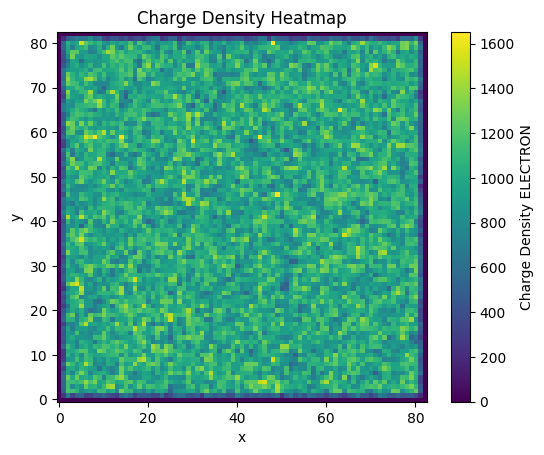

RHO_Background 
 [[-975.46105777 -975.46105777 -975.46105777 ... -975.46105777
  -975.46105777 -975.46105777]
 [-975.46105777 -975.46105777 -975.46105777 ... -975.46105777
  -975.46105777 -975.46105777]
 [-975.46105777 -975.46105777 -975.46105777 ... -975.46105777
  -975.46105777 -975.46105777]
 ...
 [-975.46105777 -975.46105777 -975.46105777 ... -975.46105777
  -975.46105777 -975.46105777]
 [-975.46105777 -975.46105777 -975.46105777 ... -975.46105777
  -975.46105777 -975.46105777]
 [-975.46105777 -975.46105777 -975.46105777 ... -975.46105777
  -975.46105777 -975.46105777]]


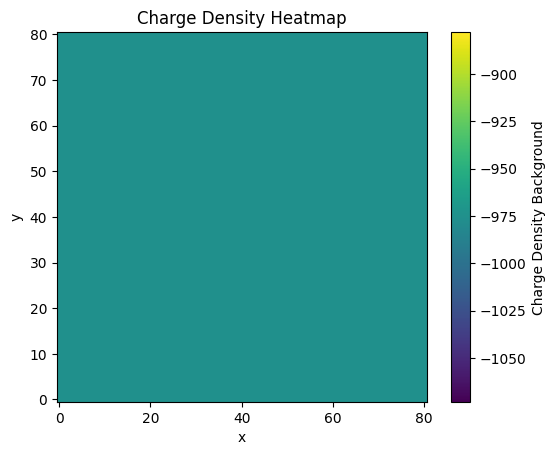

RHO_Background frame 
 [[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.         -975.46105777 -975.46105777 ... -975.46105777
  -975.46105777    0.        ]
 [   0.         -975.46105777 -975.46105777 ... -975.46105777
  -975.46105777    0.        ]
 ...
 [   0.         -975.46105777 -975.46105777 ... -975.46105777
  -975.46105777    0.        ]
 [   0.         -975.46105777 -975.46105777 ... -975.46105777
  -975.46105777    0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]
Total background charge :  -6400000.0


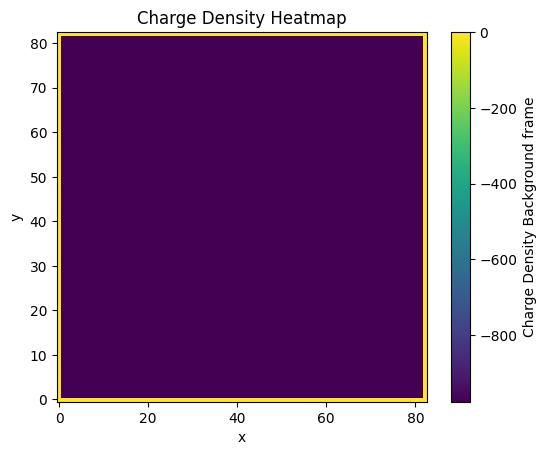

RHO total 
 [[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.         -718.65079882 -273.39586307 ... -578.64410553
  -759.73218173    0.        ]
 [   0.         -459.35477513  209.39501914 ...  276.13488917
  -480.35894895    0.        ]
 ...
 [   0.         -425.60790358   77.26271079 ...  318.49617753
  -414.24093478    0.        ]
 [   0.         -757.28964304 -491.3849278  ... -124.69162777
  -679.87033112    0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]
Total charge system :  -1.9281287677586079e-10


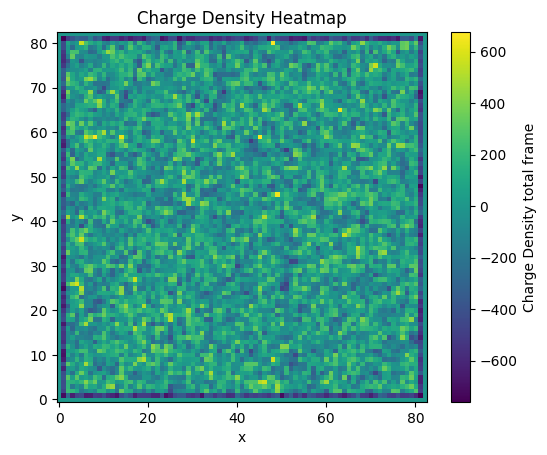

RHO WITH GHOST 
 [[-679.87033112 -757.28964304 -491.3849278  ... -124.69162777
  -679.87033112 -757.28964304]
 [-759.73218173 -718.65079882 -273.39586307 ... -578.64410553
  -759.73218173 -718.65079882]
 [-480.35894895 -459.35477513  209.39501914 ...  276.13488917
  -480.35894895 -459.35477513]
 ...
 [-414.24093478 -425.60790358   77.26271079 ...  318.49617753
  -414.24093478 -425.60790358]
 [-679.87033112 -757.28964304 -491.3849278  ... -124.69162777
  -679.87033112 -757.28964304]
 [-759.73218173 -718.65079882 -273.39586307 ... -578.64410553
  -759.73218173 -718.65079882]]


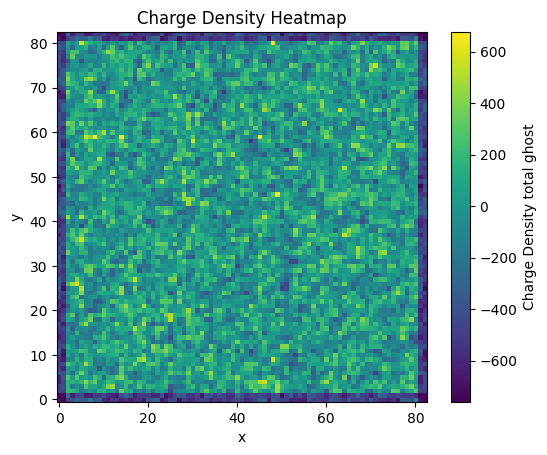

v_ELECTRON 
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -4.47625617 -3.13929677 ... -5.01249164 -5.39606576
   0.        ]
 [ 0.         -3.53645077 -0.09633696 ... -1.49050588 -4.70079474
   0.        ]
 ...
 [ 0.         -5.46112391 -4.12559179 ...  1.33314092 -2.71273308
   0.        ]
 [ 0.         -5.68603914 -5.45021753 ... -1.44254193 -3.69456223
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
378552.0022785603


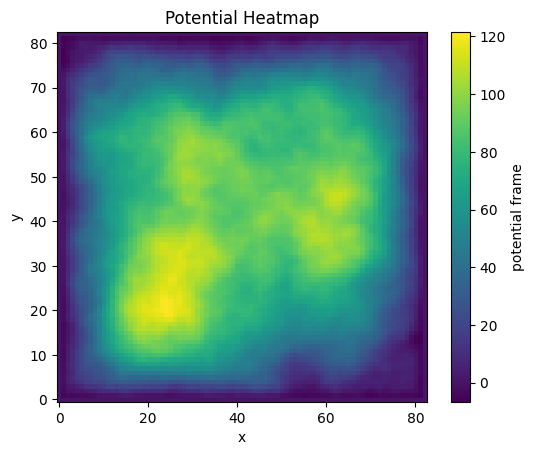

v_ELECTRON 
 [[-3.69456223 -5.68603914 -5.45021753 ... -1.44254193 -3.69456223
  -5.68603914]
 [-5.39606576 -4.47625617 -3.13929677 ... -5.01249164 -5.39606576
  -4.47625617]
 [-4.70079474 -3.53645077 -0.09633696 ... -1.49050588 -4.70079474
  -3.53645077]
 ...
 [-2.71273308 -5.46112391 -4.12559179 ...  1.33314092 -2.71273308
  -5.46112391]
 [-3.69456223 -5.68603914 -5.45021753 ... -1.44254193 -3.69456223
  -5.68603914]
 [-5.39606576 -4.47625617 -3.13929677 ... -5.01249164 -5.39606576
  -4.47625617]]


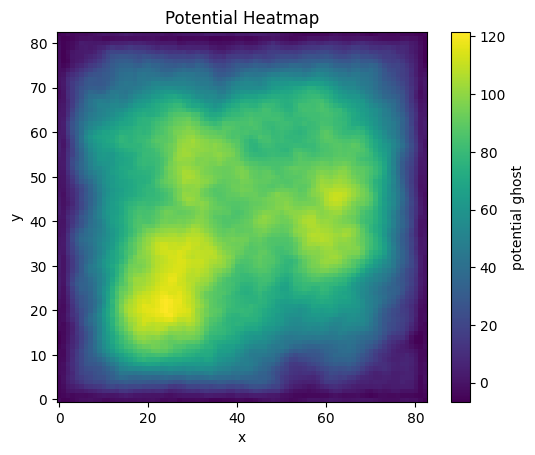

E_AT_GRID: (array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  -8.59835347, -21.41552225, ...,   0.1918558 ,
          4.02493004,   0.        ],
       [  0.        ,  -8.3243625 , -20.26995901, ..., -18.95472028,
         -3.94123425,   0.        ],
       ...,
       [  0.        ,   1.21483672,   6.94140266, ...,  13.19900534,
          6.71057773,   0.        ],
       [  0.        ,  -3.93947097,  -3.94518011, ...,  25.38253024,
         10.73333074,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]]), array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  -9.027076  ,  -3.05639451, ...,   5.09755384,
         -2.14494188,   0.        ],
       [  0.        , -18.41783112, -18.5117258 , ...,  17.6476239 ,
          8.18377959,   0.        ],
       ...,
       [

TypeError: Invalid shape (2, 83, 83) for image data

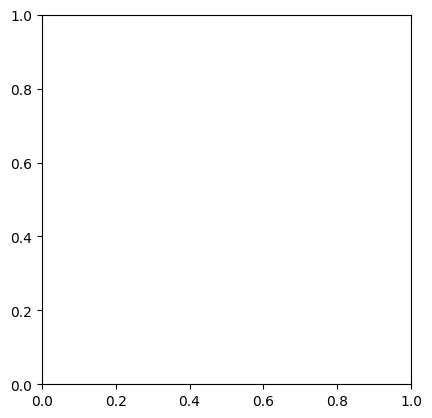

In [48]:
' TESTS '

rho_electron = charge_density(position_x, position_y, dx, dy, length)
print("RHO_ELECTRON \n", rho_electron)
print("Total charge electron : ", np.sum(rho_electron))
#rho = ghost(rho_electron)
#print('RHO GHOST\n', rho)
plt.imshow(rho_electron, origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density ELECTRON')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()


background_charge_density, background_charge_density_frame = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)
print("RHO_Background \n", background_charge_density)
plt.imshow(background_charge_density, origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density Background')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()


print("RHO_Background frame \n", background_charge_density_frame)
print("Total background charge : ", np.sum(background_charge_density))
plt.imshow(background_charge_density_frame, origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density Background frame')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()


rho_total = background_charge_density_frame + rho_electron
print("RHO total \n", rho_total)
print("Total charge system : ", np.sum(rho_total))
plt.imshow(rho_total, origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density total frame')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()




rho = ghost(rho_total)
print("RHO WITH GHOST \n", rho_total)
plt.imshow(rho, origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density total ghost')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()




potential = calculate_potential(rho, dx, dy)
print("v_ELECTRON \n", potential)
print(np.sum(potential))
plt.imshow(potential, origin='lower', cmap='viridis')
plt.colorbar(label='potential frame')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential Heatmap')
plt.show()



potential_ghost = ghost(potential)
print("v_ELECTRON \n", potential_ghost)
plt.imshow(potential_ghost, origin='lower', cmap='viridis')
plt.colorbar(label='potential ghost')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential Heatmap')
plt.show()

E_field = calculate_electric_field(potential_ghost, dx, dy)
print("E_AT_GRID:", E_field)
plt.imshow(E_field, origin='lower', cmap='viridis')
plt.colorbar(label='Electric field at grids frame')
plt.xlabel('x')
plt.ylabel('y')
plt.title('E field Heatmap')
plt.show()



"""
E_x_at_grid, E_y_at_grid, k_sq, electric_potential_grid = poisson_solver(rho_total, dx, dy)
print(" EX AT GRID : \n",E_x_at_grid)
print(np.sum(E_x_at_grid))
print(" EY AT GRID : \n",E_y_at_grid)
print(np.sum(E_y_at_grid))
print("K SQUARE : \n",k_sq)
print(np.sum(k_sq))
print(" Electric potential at grid : \n",electric_potential_grid)
print(np.sum(electric_potential_grid))

Ex_at_particle, Ey_at_particle, force_x, force_y, acc_x, acc_y = interpolate_field (position_x, position_y, dx, dy, length, E_x_at_grid, E_y_at_grid)
print(" EX AT PARTICLE : \n",Ex_at_particle)
print(np.sum(Ex_at_particle))
print(" EY AT PARTICLE : \n",Ey_at_particle)
print(np.sum(Ey_at_particle))
"""

In [ ]:
'''
for step in range(n_step):
    timesteps_list.append(iteration)
    #pos_x_list = position_x
    #print(" POSITION X COORDINATES FOR EACH ITERATIONS \n", pos_x_list)
    #vel_x_list.append(vel_x)

    ke_particle, ke_system, vel_resultant = kinetic_energy(vel_x, vel_y, particle_mass)
    ke_system_list.append(ke_system)


    rho_electron = charge_density(position_x, position_y, dx, dy, length)
    background_charge_density= calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)   #, background_charge_density_frame
    rho_total = background_charge_density + rho_electron
    #rho = ghost(rho_total)

    E_grid_x, E_grid_y, k_square, electric_potential_grid = poisson_solver(rho_total, dx, dy)

    Ex_at_particle, Ey_at_particle, force_x, force_y, acceleration_x, acceleration_y = interpolate_field(position_x, position_y, dx, dy, length, E_grid_x, E_grid_y)

    vx_half = vel_x + (0.5 * dt * acceleration_x)
    vy_half = vel_y + (0.5 * dt * acceleration_y)

    position_x += vx_half * dt
    position_y += vy_half * dt

    rho_electron = charge_density(position_x, position_y, dx, dy, length)
    background_charge_density = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)    #, background_charge_density_frame
    rho_total = background_charge_density + rho_electron
    #rho = ghost(rho_total)

    E_grid_x, E_grid_y, k_square, electric_potential_grid = poisson_solver(rho_total, dx, dy)

    Ex_at_particle, Ey_at_particle, force_x, force_y, acceleration_x, acceleration_y = interpolate_field(position_x, position_y, dx, dy, length, E_grid_x, E_grid_y)

    vel_x = vx_half + 0.5 * dt * acceleration_x
    vel_y = vy_half + 0.5 * dt * acceleration_y

    iteration += 1
    print("ITERATION : ", iteration)



    # Plotting histogram
    #plt.hist(vel_resultant, bins=150, density=True, alpha=0.75)
    #plt.xlabel('Velocity')
    #plt.ylabel('Probability Density')
    #plt.title('Probability Distribution of Particle Velocities')
    #plt.grid(True)
    #plt.xlim([0, 1])  # Replace min_velocity and max_velocity with your desired limits
    #plt.ylim([0, 20])
    #plt.show()

    plt.imshow(E_grid_x, origin='lower', cmap='viridis')
    plt.colorbar(label='Charge Density')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Charge Density Heatmap')
    plt.show()

    t += dt
'''

In [ ]:
'''
#print("END POSITION X COORDINATES : \n ",pos_x_list)
print("Length of timesteps_list:", len(timesteps_list))
print("Length of ke_system_list:", len(ke_system_list))
'''

In [ ]:
'''
plt.plot(timesteps_list, ke_system_list, linestyle='-')
plt.title('Kinetic Energy vs Timestep')
plt.xlabel('Timestep')
plt.ylabel('Kinetic Energy')
#plt.grid(True)
plt.show()




plt.imshow(rho, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()


plt.imshow(electric_potential_grid, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='ELECTRIC POTENTIAL')
plt.xlabel('x')
plt.ylabel('y')
plt.title('ELECTRIC POTENTIAL HEAT MAP')
plt.show()

plt.imshow(k_square, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='K SQUARE')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K SQUARE HEAT MAP')
plt.show()
'''


'''
plt.imshow(rho_electron, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()

plt.imshow(background_charge_density, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()

plt.imshow(rho_total, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()
'''